## <center><font color=navy>Data Science for Quantitative Finance</font></center>
### <center>Portfolio Optimization in Python</center>
### <center> Ali Habibnia</center>

    
<center> Assistant Professor, Department of Economics, </center>
<center> and Division of Computational Modeling & Data Analytics at Virginia Tech</center>
 <center> habibnia@vt.edu </center> 

### Readings:

Chapter 11,12 from "[Introduction to Computational Finance and Financial Econometrics](https://bookdown.org/compfinezbook/introcompfinr/)" by Eric Zivot 




<img style="float: left; border: 10px solid white" src="https://www.nobelprize.org/images/markowitz-13420-portrait-medium.jpg" width=150 height=200 />

   Harry Markowitz introduced modern portfolio theory in his 1952 [paper](https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf) titled Portfolio Selection. He begins by outlining that portfolio selection is a two-step process; firstly, an investor must consider the future performance of the available assets (in terms of both risk and return) and subsequently, a decision can be made about how to construct the portfolio (i.e. how much money to allocate to each asset).
    Markowitz focuses on the portfolio construction aspect and leaves the more speculative task of predicting future performance to the reader. In fact, throughout the paper, returns are assumed to follow a simple Gaussian (Normal) distribution. This assumption is the foundation upon which the whole of modern portfolio theory is based but has been the cause for much criticism as stock price returns have been shown not to follow a normal distribution.


### Download the Crypto Prices

Let’s put the critics to one side and write some Python code to plot the Markowitz bullet and understand better the mathematical theory that earned Markowitz his Nobel prize.

For this demonstration, We pick cryptos with the highest market caps or trading volumes with enough sample size. See https://coinmarketcap.com/


In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install missingno

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

,BTC-USD,ETH-USD,XRP-USD,USDT-USD,LTC-USD,BCH-USD,LINK-USD,ADA-USD,BNB-USD,USDC-USD,...,LUNA1-USD,DOGE-USD,MATIC-USD,BUSD-USD,CRO-USD,WBTC-USD,BCH-USD,TRX-USD,FTM-USD,XLM-USD
2022-03-27 00:00:00,46820.492188,3291.577637,0.857343,1.000376,129.397476,376.537445,16.849527,1.182148,430.503265,1.000039,...,94.151543,0.144732,1.693481,1.000912,0.485139,46756.945312,376.537445,0.069170,1.430095,0.229787
2022-03-28 00:00:00,47128.003906,3336.634521,0.863304,1.000412,127.938614,368.139282,16.517033,1.170184,430.390869,1.000126,...,97.328468,0.142657,1.660387,0.999873,0.481083,47127.957031,368.139282,0.069081,1.403734,0.230426
2022-03-29 00:00:00,47465.730469,3401.987793,0.858000,1.000450,130.061234,373.529968,16.973129,1.191112,434.505676,0.999996,...,108.988426,0.144470,1.674787,0.998623,0.480683,47491.414062,373.529968,0.069382,1.418792,0.233362
2022-03-30 00:00:00,47062.664062,3385.157959,0.860814,1.000278,131.169342,379.637817,17.209745,1.190385,442.684845,0.999431,...,106.015793,0.143210,1.684619,0.999200,0.474019,47076.789062,379.637817,0.073087,1.409386,0.234819
2022-03-31 00:00:00,45538.675781,3281.642822,0.814564,1.000304,123.716011,384.044342,16.910994,1.141851,428.916107,0.999447,...,103.011383,0.137826,1.617286,1.001186,0.460359,45554.726562,384.044342,0.073876,1.423092,0.228277


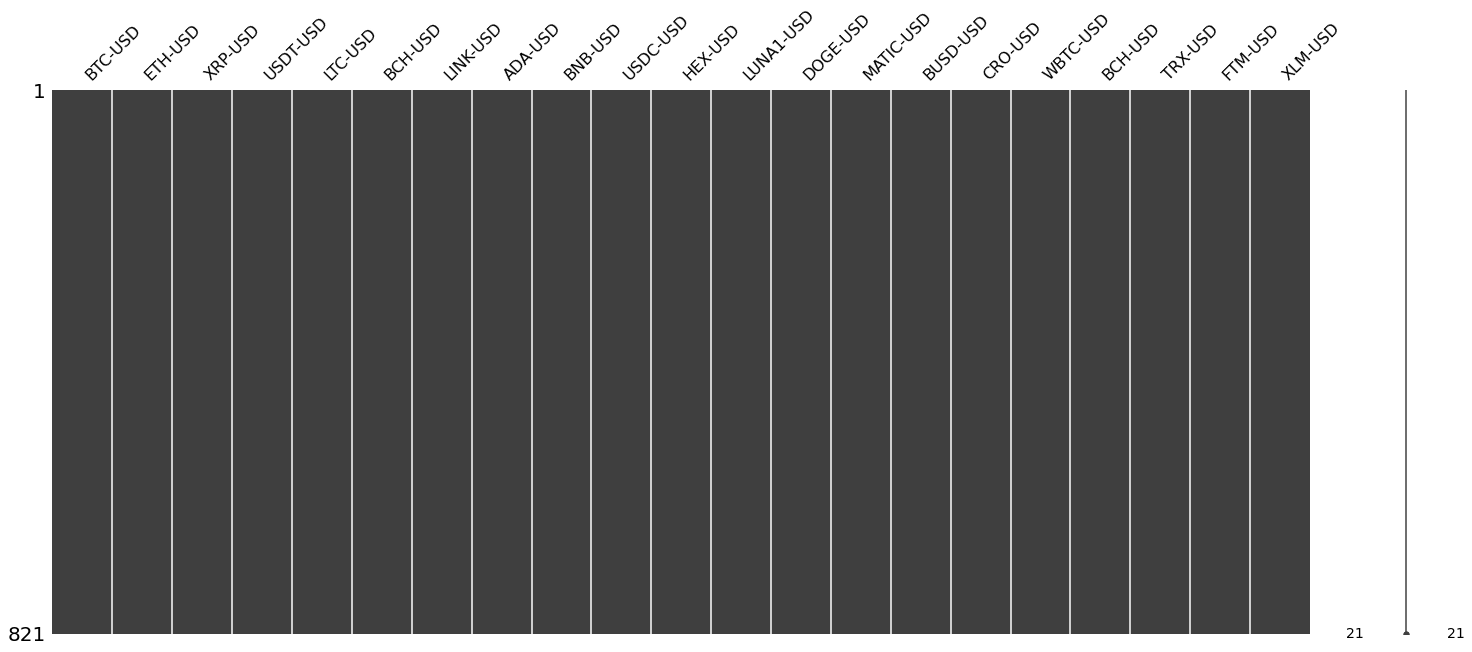

In [63]:
symbols = ['BTC-USD','ETH-USD','XRP-USD','USDT-USD','LTC-USD','BCH-USD','LINK-USD','ADA-USD','BNB-USD', 'USDC-USD', 'HEX-USD', 'LUNA1-USD', 'DOGE-USD', 'MATIC-USD', 'BUSD-USD', 'CRO-USD', 'WBTC-USD', 'BCH-USD', 'TRX-USD', 'FTM-USD', 'XLM-USD'] #
Pr = pd.DataFrame()
for symbol in symbols:
    tmp_close = yf.download(symbol, 
                      start='2020-01-01', 
                      end='2022-03-31', 
                      progress=False)['Adj Close']
    Pr = pd.concat([Pr, tmp_close], axis=1)
Pr.columns=symbols
msno.matrix(Pr)
Pr.tail()

In [64]:
re = np.log(Pr/Pr.shift(1)).dropna(how="any")
re.tail()

,BTC-USD,ETH-USD,XRP-USD,USDT-USD,LTC-USD,BCH-USD,LINK-USD,ADA-USD,BNB-USD,USDC-USD,...,LUNA1-USD,DOGE-USD,MATIC-USD,BUSD-USD,CRO-USD,WBTC-USD,BCH-USD,TRX-USD,FTM-USD,XLM-USD
2022-03-27 00:00:00,0.050813,0.046132,0.029078,0.000015,0.035525,0.039668,0.062927,0.027055,0.034462,0.000147,...,0.029792,0.063200,0.050053,-0.000443,0.058342,0.049258,0.039668,0.044461,0.021891,0.064359
2022-03-28 00:00:00,0.006546,0.013596,0.006929,0.000036,-0.011338,-0.022556,-0.019930,-0.010172,-0.000261,0.000087,...,0.033186,-0.014441,-0.019735,-0.001039,-0.008396,0.007904,-0.022556,-0.001287,-0.018605,0.002777
2022-03-29 00:00:00,0.007141,0.019397,-0.006163,0.000038,0.016455,0.014537,0.027239,0.017726,0.009515,-0.000130,...,0.113150,0.012629,0.008635,-0.001251,-0.000832,0.007683,0.014537,0.004348,0.010670,0.012661
2022-03-30 00:00:00,-0.008528,-0.004959,0.003274,-0.000172,0.008484,0.016219,0.013844,-0.000611,0.018649,-0.000565,...,-0.027654,-0.008760,0.005853,0.000578,-0.013961,-0.008769,0.016219,0.052023,-0.006652,0.006224
2022-03-31 00:00:00,-0.032918,-0.031056,-0.055225,0.000026,-0.058500,0.011540,-0.017512,-0.041626,-0.031597,0.000016,...,-0.028749,-0.038320,-0.040790,0.001986,-0.029241,-0.032866,0.011540,0.010738,0.009678,-0.028255


<AxesSubplot:>

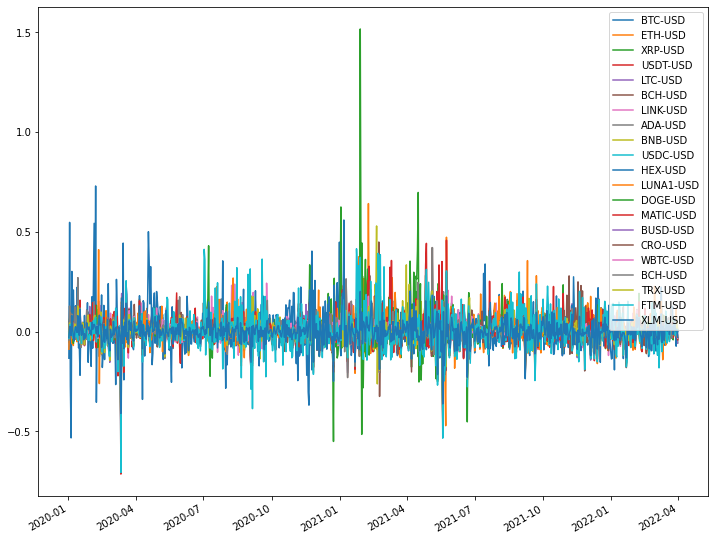

In [65]:
re.plot(figsize=(12,10))

In [66]:
# mean daily returns per coin 
print(re.mean())

# mean daily returns of all cryptos
print('mean of all cryptos=',re.mean().mean())

BTC-USD      2.249337e-03
ETH-USD      3.929774e-03
XRP-USD      1.758158e-03
USDT-USD     5.706382e-07
LTC-USD      1.316948e-03
BCH-USD      7.691356e-04
LINK-USD     2.727433e-03
ADA-USD      4.305018e-03
BNB-USD      4.200808e-03
USDC-USD    -5.638845e-06
HEX-USD      9.231179e-03
LUNA1-USD    7.439140e-03
DOGE-USD     5.142048e-03
MATIC-USD    5.710965e-03
BUSD-USD    -2.646391e-06
CRO-USD      3.178586e-03
WBTC-USD     2.245613e-03
BCH-USD      7.691356e-04
TRX-USD      2.095598e-03
FTM-USD      5.974939e-03
XLM-USD      1.968201e-03
dtype: float64
mean of all cryptos= 0.003095443011812656


### Minimize the Risk of the Portfolio (minimum variance portfolio)

Our goal is to construct a portfolio from those cryptos with the following constraints:

- The expected daily return is higher than the average of all of them, i.e. greater than 0.003
- There is no short selling, i.e. we only buy crypto, so the sum of the weights of all coins will ad up to 1
- Every coin can get a weight from 0 to 1, i.e. we can even build a portfolio of only one coin, or we can exclude some coins.
- Finally, our objective is to minimize the variance (i.e. risk) of the portfolio. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

We could also solve the optimization by maximizing the Portfolio Return, Sharpe Ratio or other portfolio perforemance measurments.

Sharpe Ratio developed by Nobel Laureate William F. Sharpe, and is a measure for calculating risk-adjusted return and has been the industry standard for such calculations.

The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk. The formula for the Sharpe ratio is provided below:

### $Sharpe = \frac{R_P-R_f}{\sigma_p} $

In [101]:
# the objective function is to minimize the portfolio risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(re.cov()).dot(weights.T)
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        {"type": "ineq", "fun": lambda x: np.sum(re.mean()*x)-0.003})
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(re.shape[1]))
# Initialize the weights with an even split
# In out case each coin will have (1/# of coins) % at the beginning
guess = [1./re.shape[1] for x in range(re.shape[1])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results # The optimum weights

     fun: 0.0005874057439480315
     jac: array([1.12830329e-03, 1.58040201e-03, 1.52091381e-03, 6.54166070e-06,
       1.63608934e-03, 1.67828988e-03, 1.89010376e-03, 1.64123533e-03,
       1.63121344e-03, 7.91384809e-06, 3.48618723e-03, 3.00927999e-03,
       2.00778132e-03, 2.13776829e-03, 2.68330768e-06, 1.35496110e-03,
       1.12135375e-03, 1.67828988e-03, 1.45704205e-03, 2.50103181e-03,
       1.53911990e-03])
 message: 'Optimization terminated successfully'
    nfev: 396
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([8.67361738e-19, 8.61378869e-03, 1.08420217e-18, 1.94333207e-01,
       3.90312782e-18, 0.00000000e+00, 0.00000000e+00, 2.45964552e-02,
       2.59144834e-02, 1.91828970e-01, 1.30874868e-01, 1.50408806e-01,
       3.79366776e-02, 2.54460794e-02, 1.95638215e-01, 0.00000000e+00,
       1.70709238e-04, 0.00000000e+00, 6.50521303e-19, 1.42377400e-02,
       0.00000000e+00])

In [106]:
pd.DataFrame(list(zip(symbols, optimized_results.x)), 
                       columns=['Symbol', 'Weight'])

,Symbol,Weight
0,BTC-USD,8.673617e-19
1,ETH-USD,8.613789e-03
2,XRP-USD,1.084202e-18
3,USDT-USD,1.943332e-01
4,LTC-USD,3.903128e-18
5,BCH-USD,0.000000e+00
6,LINK-USD,0.000000e+00
7,ADA-USD,2.459646e-02
8,BNB-USD,2.591448e-02
9,USDC-USD,1.918290e-01


In [21]:
np.sum(optimized_results.x)

1.0

we can see that the expected return of the portfolio is

In [22]:
np.sum(re.mean()*optimized_results.x)

0.0029999999999911708

### Portfolio Optimization: Monte Carlo Simulation

One thing we could do is just check a bunch of random allocations and see which one has the best Sharpe Ratio, PR or min Var.

What we're going to do is randomly assign a weight to each asset in our portfolio, and then calculate the mean daily return and standard deviation of return. This allows us to calculate the Sharpe Ratio for many randomly selected allocations.

What we're looking for is which random allocation has the best Sharpe Ratio.

**One thing to note is that guessing and checking is not the most efficient way to optimize a portfolio — instead, we can use math and optimization algorithm such as brevious section to determine the optimal Sharpe Ratio for a given portfolio.**

Before we run thousands of random allocations, let's do a single random allocation. To do this we're going to:

- Set our weights to a random NumPy array
- Rebalance the weights so they add up to one
- Calculate the expected portfolio return
- Calculate the expected portfolio volatility
- Calculate the Sharpe Ratio

Keep in mind this portfolio is generally intended to be a yearly investment, so we're going to multiply return and the covariance by 252 to get the annualized return and the covariance. For the U.S. stock market, the average number of trading days is about 252 days. 

**Cryptocurrencies can be traded 24 hours a day, 365 days a year, including weekends and holidays.**

In [41]:
weights = np.array(np.random.random(re.shape[1]))
print('Random Weights:')
print(weights)

print('Rebalance')
weights = weights/np.sum(weights)
print(weights)

# expected return
print('Expected Portfolio Return')
exp_ret = np.sum((re.mean()*weights)*365) #
print(exp_ret)

# expected volatility
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T,np.dot(re.cov()*365, weights)))
print(exp_vol)

# Sharpe Ratio
print('Sharpe Ratio')
SR = exp_ret/exp_vol
print(SR)

Random Weights:
[0.95592357 0.59679635 0.1837611  0.18708303 0.55670743 0.72268675
 0.7232567  0.4156981  0.19960899 0.75367006 0.44997181 0.52685258
 0.29562713 0.22441647 0.58115121 0.49282043 0.12718621 0.13963373
 0.88912554 0.75626897 0.79733746]
Rebalance
[0.09038968 0.05643153 0.01737598 0.01769009 0.05264082 0.0683354
 0.06838929 0.03930734 0.01887451 0.0712651  0.04254818 0.04981783
 0.02795374 0.02122024 0.05495216 0.04659983 0.0120264  0.01320341
 0.08407342 0.07151085 0.07539418]
Expected Portfolio Return
0.003000157130350533
Expected Volatility
0.04229504024875488
Sharpe Ratio
0.07093401762252383


In [89]:
num_ports = 1000
all_weights = np.zeros((num_ports, len(re.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    # weights 
    weights = np.array(np.random.random(re.shape[1])) 
    weights = weights/np.sum(weights)  
    
    # save the weights
    all_weights[ind,:] = weights

    # expected return 
    ret_arr[ind] = np.sum((re.mean()*365*weights))

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(re.cov()*365, weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [90]:
sharpe_arr.max()

1.7632957772215276

In [91]:
sharpe_arr.argmax()

637

In [92]:
all_weights[sharpe_arr.argmax(),:]

array([0.09266442, 0.02129709, 0.01469682, 0.08881617, 0.01071416,
       0.02072748, 0.00109371, 0.07534827, 0.05456397, 0.0263195 ,
       0.08880757, 0.06009142, 0.05558948, 0.08691258, 0.0817369 ,
       0.02487282, 0.07796205, 0.03463224, 0.04792619, 0.01805123,
       0.01717592])

Text(0, 0.5, 'Return')

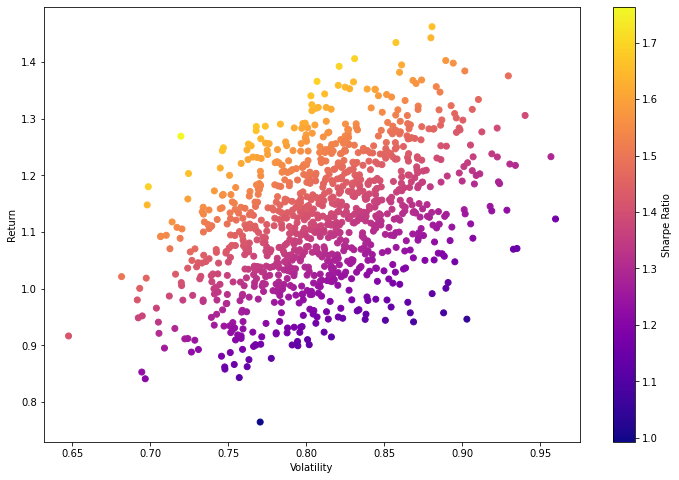

In [93]:
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

Let's now put a red dot at the location of the maximum Sharpe Ratio.

In [94]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

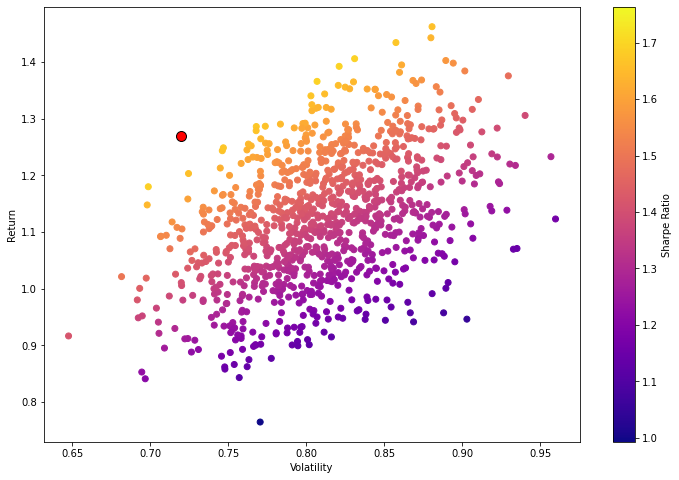

In [98]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# add a red dot for max_sr_vol & max_sr_ret
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=100, edgecolors='black')